# Robustness tokens

Recently, [Vision Transformers Need Registers
 by Darcet et al.](https://arxiv.org/abs/2309.16588) and [Efficient Streaming Language Models with Attention Sinks by Xiao et.](https://arxiv.org/abs/2309.17453) have proposed adding additional tokens to the input sequence of transformer models to get rid of artifacts in the attention maps of vision models and to improve performances of language models on large sequences respectively.

This promising trend of adding additional tokens to the transformer architecture that do not represent the input sequence, but that are being used by the transformer to improve its performances, is very interesting.

In this work, we propose robustness tokens. The idea is to use additional tokens (a.k.a registers) to improve the robustness of ViT to adversarial attacks.

In [1]:
import torch
from torch.optim import Adam
from torch.nn.functional import cosine_similarity, mse_loss

import pytorch_lightning as pl

from PIL import Image
import requests as r
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, ToPILImage

pl.seed_everything(0)

/home/users/p/pulfer/.conda/envs/rtokens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


0

In [2]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

normalize = Normalize(imagenet_mean, imagenet_std)
unnormalize = Normalize(
    [-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    [1/s for s in imagenet_std]
)

to_pil = ToPILImage()

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    normalize
])

to_img = Compose([
    unnormalize,
    to_pil
])

def get_image_tensor(url):
    image = Image.open(r.get(url, stream=True).raw)
    return transform(image).unsqueeze(0).cuda()

URL_IMG_1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
URL_IMG_2 = "http://images.cocodataset.org/val2017/000000000139.jpg"

In [34]:
class DinoV2Robustifier(pl.LightningModule):
    def __init__(self, model, enbable_robust=False, return_cls=False, n_rtokens=1):
        super(DinoV2Robustifier, self).__init__()
        self.model = model
        self.enbable_robust = enbable_robust
        self.return_cls = return_cls
        self.n_rtokens = n_rtokens
        
        hidden_dim = self.model.cls_token.shape[-1]
        # self.rob_tokens = torch.nn.Parameter(torch.randn(1, n_rtokens, hidden_dim))
        self.rob_tokens = torch.nn.Parameter(torch.zeros(1, n_rtokens, hidden_dim))
        
    def forward(self, x, enable_robust=None, return_cls=None):
        b, c, w, h = x.shape
        
        # Embedding patches
        x = self.model.patch_embed(x)
        
        # Concatenating class token
        x = torch.cat((self.model.cls_token.expand(b, -1, -1), x), dim=1)
        x += self.model.interpolate_pos_encoding(x, w, h)
        
        # Appending robust token
        if enable_robust is True or (enable_robust is None and self.enbable_robust):
            x = torch.cat((x, self.rob_tokens.repeat(b, 1, 1)), dim=1)
        
        # Running blocks
        for blk in self.model.blocks:
            x = blk(x)
        x = self.model.norm(x)
        
        if return_cls is True or (return_cls is None and self.return_cls):
            return self.model.head(x[:, 0])

        return x

In [4]:
def psnr_to_mse(psnr):
    return 10 ** (-psnr / 10)

def quantize(batch):
    imgs = [unnormalize(img).clamp(0, 1) for img in batch]
    imgs = [normalize(img) for img in imgs]
    batch = torch.stack(imgs).cuda()
    return batch

def pgd_attack(model, batch, steps=350, lr=4e-4, max_mse=1e-4, eps=8/255, verbose=False):
    model.eval()
    with torch.no_grad():
        target = model(batch).detach()
        img_target = unnormalize(batch).detach()

    lower, upper = batch.min(), batch.max()
    batch_adv = (batch + lr * torch.randn_like(batch)).detach().clone()
    batch_adv.requires_grad = True
    for step in range(steps):
        # Minimize cosine similarity an MSE
        pred = model(batch_adv)
        img_pred = unnormalize(batch_adv)

        f_loss = cosine_similarity(pred, target).mean()
        i_loss = mse_loss(img_pred, img_target).mean()
        loss = f_loss + i_loss

        loss.backward()
        batch_adv.data = batch_adv.data - lr * batch_adv.grad.sign()
        batch_adv.grad.zero_()

        # Projection
        if eps is not None:
            batch_adv = batch + torch.clamp(batch_adv - batch, -eps, eps)

        # Stay within range
        batch_adv = torch.clamp(batch_adv, lower, upper).clone().detach()
        batch_adv.requires_grad = True

        # Print progress
        if verbose and ((step + 1) % (steps // 10) == 0 or step == 0):
            print(f"Step {step+1}/{steps}: {loss.item():.3f}")

        # Stop if MSE is too high
        if max_mse is not None:
            if i_loss >= max_mse:
                break

    # Quantizing
    batch_adv = quantize(batch_adv)
    return batch_adv.clone().detach()


In [49]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model = DinoV2Robustifier(
    dinov2,
    enbable_robust=False,
    return_cls=False,
    n_rtokens=10
).cuda().eval()

# Sanity check
x = get_image_tensor(URL_IMG_1)
with torch.no_grad():
    y1 = dinov2(x)
    y2 = model(x, enable_robust=False, return_cls=True)
    y3 = model(x, enable_robust=True, return_cls=True)
    
    assert torch.allclose(y1, y2, atol=1e-6)
    assert not torch.allclose(y1, y3, atol=1e-6)

Using cache found in /home/users/p/pulfer/.cache/torch/hub/facebookresearch_dinov2_main


Step 1/20: 1.000
Step 2/20: 0.946
Step 4/20: 0.765
Step 6/20: 0.606
Step 8/20: 0.477
Step 10/20: 0.252
Step 12/20: 0.154
Step 14/20: 0.120
Step 16/20: 0.094
Step 18/20: 0.087
Step 20/20: 0.073
MSE: 0.00004
Cosine similarity: -0.10


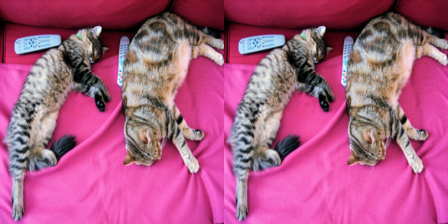

In [50]:
x_adv = pgd_attack(model, x, steps=20, lr=0.01, eps=8/255, verbose=True)
f1, f2 = dinov2(x), dinov2(x_adv)
imgt, imgtadv = unnormalize(x), unnormalize(x_adv)
print(f"MSE: {((imgt - imgtadv) ** 2).mean():.5f}")
print(f"Cosine similarity: {torch.cosine_similarity(f1, f2).mean():.2f}")

to_pil(torch.cat((imgt, imgtadv), dim=-1)[0])

In [51]:
def train_robustness_token(model, x, x_adv, steps=600, lr=1e-4, verbose=False):
    optim = Adam([model.rob_tokens], lr=lr)
    
    with torch.no_grad():
        model.enbable_robust = False
        target = model(x).detach().clone()
    
    model.enbable_robust = True
    for step in range(steps):
        pred = model(x_adv)[:, :-model.n_rtokens]
        loss = -torch.cosine_similarity(pred, target).mean()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if verbose and (step % (steps//10) == 0 or step == 0):
            print(f"Step {step+1}/{steps} cossim:\t{-loss.item():.2f}")

In [52]:
train_robustness_token(model, x, x_adv, steps=100, lr=1e-2, verbose=True)

Step 1/100 cossim:	0.18
Step 11/100 cossim:	0.55
Step 21/100 cossim:	0.60
Step 31/100 cossim:	0.67
Step 41/100 cossim:	0.70
Step 51/100 cossim:	0.73
Step 61/100 cossim:	0.76
Step 71/100 cossim:	0.78
Step 81/100 cossim:	0.80
Step 91/100 cossim:	0.82


In [53]:
model.return_cls = True
for img_url in [URL_IMG_1, URL_IMG_2]:
    x = get_image_tensor(img_url)
    x_adv_1 = pgd_attack(dinov2, x, steps=20, lr=1e-2)
    x_adv_2 = pgd_attack(model, x, steps=20, lr=1e-2)
    
    with torch.no_grad():
        print("\n\n Image: ", img_url)
        fx, fxadv = dinov2(x), dinov2(x_adv_1)
        frx, frxadv = model(x), model(x_adv_2)
        print(f"\tCosine similarity default: {torch.nn.functional.cosine_similarity(fx, fxadv).mean():.2f}")
        print(f"\tCosine similarity robust: {torch.nn.functional.cosine_similarity(frx, frxadv).mean():.2f}")
        print(f"\tCosine similarity between default and robust for original image: {torch.nn.functional.cosine_similarity(fx, frx).mean():.2f}")



 Image:  http://images.cocodataset.org/val2017/000000039769.jpg
	Cosine similarity default: -0.26
	Cosine similarity robust: 0.40
	Cosine similarity between default and robust for original image: 0.95


 Image:  http://images.cocodataset.org/val2017/000000000139.jpg
	Cosine similarity default: -0.29
	Cosine similarity robust: -0.20
	Cosine similarity between default and robust for original image: 0.95


In [54]:
sd1 = dinov2.state_dict()
sd2 = model.model.state_dict()

for k in sd1.keys():
    assert torch.allclose(sd1[k], sd2[k], atol=1e-6), "Found different parameters!"

print("All parameters are equal (except robust token)!")

All parameters are equal (except robust token)!


# Conclusion

In this small example, we saw that a DinoV2 model gets very different feature representations (in terms of cosine similarity between CLS tokens) for an original image and an adversarial example obtained with PGD.

To address the issue, we propose to wrap the model with robustness tokens. These tokens are appended to the input sequence of the transformers and are trained, using the adversarial example, to keep the same feature representation as the original image.

We train on a single example and see that the robustness is increased also for an unseen adversarial example.

The method is advantageous for a few reasons:
  1) It is model-agnostic and can be applied to any transformer-based model.
  2) It is simple to implement.
  3) It is computationally cheap, as few examples are needed to train the robustness tokens and only the robustness tokens are trained ($L_r \times d$ parameters, where $L_r$ is the number of robustness tokens and $d$ is the dimension of the embeddings).

Interestingly, finding an adversarial example seems to be more costly than training the robustness tokens.

Future directions:
  - Try multiple pre-trained transformer models
  - Ablate the number of robustness tokens needed and the relative performance
  - See if performances degrade on downstream tasks (e.g. classification, segmentation, etc.)
  - See if robustness tokens work for different adversarial attacks.